### Financial Index Prediction
This notebook seeks to predict if an ARMA-model has predicted a higher or lower value than the actual outcome of a financial index from day k-1 to day k given financial news headlines from day k. A range of different combinations between statistical and NLP-models are used.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm, trange
from sentence_transformers import SentenceTransformer
from sklearn.utils import parallel_backend
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.dummy import DummyClassifier
from sklearn.base import ClassifierMixin, BaseEstimator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Embedding, Masking, Lambda, Layer, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
import os
import itertools

#### Load financial news data and financial index data

In [2]:
ONEDRIVE_PATH = Path(r"C:\Users\gusta\Kidbrooke Advisory Ab\KidbrookeOneDrive - Gustaf Backman exjobb")

# Read the financial data 
fin_path = ONEDRIVE_PATH / "Input Data/stock_data.pkl"
fin_data = pd.read_pickle(fin_path)
# Read from 2006-10-20 for next day preds or from 2006-10-19 for current day preds
fin_data = fin_data.loc['2006-10-20' : '2013-11-22']

news_path = ONEDRIVE_PATH / "Input Data/financial_headlines_20061020-20131119.pkl"
news_data = pd.DataFrame(pd.read_pickle(news_path))
news_data.set_index('date',inplace=True)

In [3]:
news_dates = news_data.index.drop_duplicates()
fin_dates = fin_data.index.drop_duplicates

# Find the dates which are present in both the financial data and news data
valid_dates = []
for date in news_dates: 
    if date in fin_data.index: 
        valid_dates.append(date)
        
# Create targets for all 3 time series 
targets = pd.DataFrame(dtype='int8')
prev_vals = fin_data.iloc[0]
for i in range(len(valid_dates)): 
    y_temp = []
    # If the value has increased since yesterday, y = 1
    if prev_vals['1 YEAR'] < fin_data.iloc[i+1]['1 YEAR']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
        
    if prev_vals['3 YEAR'] < fin_data.iloc[i+1]['3 YEAR']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
        
    if prev_vals['S&P'] < fin_data.iloc[i+1]['S&P']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
    targets = targets.append({'1 YEAR':y_temp[0], '3 YEAR':y_temp[1], 'S&P':y_temp[2]}, ignore_index=True)
    prev_vals = fin_data.iloc[i+1]

In [4]:
# Concatenate the news for each day in the valid indices, i.e. the indices that are present in both 
# the financial data and the news data 
texts = []
for ind,date in enumerate(tqdm(valid_dates)): 
    temp_texts = ""
    for i,text in enumerate(news_data.loc[date]['title']): 
        if i < len(news_data.loc[date]['title']) - 1:
            temp_texts += text + ". "
        else:
            temp_texts += text + "."
    texts.append(temp_texts)
texts = np.asarray(texts)
print("Length of texts:",len(texts))
print("Length of targets:",len(targets))

100%|██████████████████████████████████████████████████████████████████████████████| 1846/1846 [00:38<00:00, 47.59it/s]

Length of texts: 1846
Length of targets: 1846


Load the ARMA-labels

In [5]:
arma_path = Path(os.getcwd()).parent / "arma_labels.npy"
arma_labels = np.load(arma_path)
# Replace the targets 
for i in range(len(targets)): 
    targets.iloc[i]['1 YEAR'] = arma_labels[i,0]
    targets.iloc[i]['3 YEAR'] = arma_labels[i,1]
    targets.iloc[i]['S&P'] = arma_labels[i,2]

#### Format the data with SBERT


In [6]:
# Load a pre-trained SBERT-model 
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [7]:
# The embeddings are the same for today/tomorrow prediction, it's just the labels that change. 
path = ONEDRIVE_PATH / "Input Data/news_embedded_today_bert_base_nli_mean.npy" 
# Check if an embedding matrix for the news dataset has been previously constructed 
if os.path.exists(path):
    x = np.load(path)
    embed_dim = x.shape[-1]
    print("Loaded previously saved embeddings.")
else:
    # Create embedding matrix for every sample with the mean embedding over all sentences in that review
    x = np.zeros((len(targets), 768))
    for i,text in enumerate(tqdm(texts)):
        sbert_texts = sbert_model.encode(sent_tokenize(text))
        x[i] = np.mean(sbert_texts,axis=0)
    np.save(path,x)

Loaded previously saved embeddings.


#### Partition into training and test set
Since the data is somewhat imbalanced - mostly for the 1 year rate - the training data will be under sampled by the minority class. 

In [8]:
zero_indices_1yr = np.where(targets['1 YEAR'] == 0)[0]
one_indices_1yr = np.where(targets['1 YEAR'] == 1)[0]

zero_indices_3yr = np.where(targets['3 YEAR'] == 0)[0]
one_indices_3yr = np.where(targets['3 YEAR'] == 1)[0]

zero_indices_sp = np.where(targets['S&P'] == 0)[0]
one_indices_sp = np.where(targets['S&P'] == 1)[0]

print(" ----- 1 YEAR RATE -----")
print("Ratio neg labels 1 year rate:",len(zero_indices_1yr) / len(targets))
print("Neg labels:", len(zero_indices_1yr), "Pos labels:",len(one_indices_1yr))
print(" ----- 3 YEAR RATE -----")
print("Ratio neg labels 3 year rate:",len(zero_indices_3yr) / len(targets))
print("Neg labels:", len(zero_indices_3yr), "Pos labels:",len(one_indices_3yr))
print(" -----     S&P     -----")
print("Ratio neg labels S&P:",len(zero_indices_sp) / len(targets))
print("Neg labels:", len(zero_indices_sp), "Pos labels:",len(one_indices_sp))

 ----- 1 YEAR RATE -----
Ratio neg labels 1 year rate: 0.6110509209100758
Neg labels: 1128 Pos labels: 718
 ----- 3 YEAR RATE -----
Ratio neg labels 3 year rate: 0.5384615384615384
Neg labels: 994 Pos labels: 852
 -----     S&P     -----
Ratio neg labels S&P: 0.5503791982665223
Neg labels: 1016 Pos labels: 830


In [9]:
n_train = 1200
n = len(targets)

np.random.shuffle(zero_indices_1yr)
np.random.shuffle(one_indices_1yr)
part_zeros_1yr = len(zero_indices_1yr) / n
train_indices_1yr = np.zeros((n_train),dtype=int)
train_indices_1yr[:round(part_zeros_1yr * n_train)] = zero_indices_1yr[:round(part_zeros_1yr * n_train)]
train_indices_1yr[round(part_zeros_1yr * n_train):] = one_indices_1yr[:round((1 - part_zeros_1yr) * n_train)]
np.random.shuffle(train_indices_1yr)
# All indices not in train is in test. 
test_indices_1yr = np.setdiff1d(np.arange(len(targets)), train_indices_1yr)
np.random.shuffle(test_indices_1yr)

np.random.shuffle(zero_indices_3yr)
np.random.shuffle(one_indices_3yr)
part_zeros_3yr = len(zero_indices_3yr) / n
train_indices_3yr = np.zeros((n_train),dtype=int)
train_indices_3yr[:round(part_zeros_3yr * n_train)] = zero_indices_3yr[:round(part_zeros_3yr * n_train)]
train_indices_3yr[round(part_zeros_3yr * n_train):] = one_indices_3yr[:round((1 - part_zeros_3yr) * n_train)]
np.random.shuffle(train_indices_3yr)
# All indices not in train is in test. 
test_indices_3yr = np.setdiff1d(np.arange(len(targets)), train_indices_3yr)
np.random.shuffle(test_indices_3yr)

np.random.shuffle(zero_indices_sp)
np.random.shuffle(one_indices_sp)
part_zeros_sp = len(zero_indices_sp) / n
train_indices_sp = np.zeros((n_train),dtype=int)
train_indices_sp[:round(part_zeros_sp * n_train)] = zero_indices_sp[:round(part_zeros_sp * n_train)]
train_indices_sp[round(part_zeros_sp * n_train):] = one_indices_sp[:round((1 - part_zeros_sp) * n_train)]
np.random.shuffle(train_indices_sp)
# All indices not in train is in test. 
test_indices_sp = np.setdiff1d(np.arange(len(targets)), train_indices_sp)
np.random.shuffle(test_indices_sp)

x_train_1yr = x[train_indices_1yr]
x_test_1yr = x[test_indices_1yr]
y_train_1yr = targets.iloc[train_indices_1yr]['1 YEAR'].values
y_test_1yr = targets.iloc[test_indices_1yr]['1 YEAR'].values

x_train_3yr = x[train_indices_3yr]
x_test_3yr = x[test_indices_3yr]
y_train_3yr = targets.iloc[train_indices_3yr]['3 YEAR'].values
y_test_3yr = targets.iloc[test_indices_3yr]['3 YEAR'].values

x_train_sp = x[train_indices_sp]
x_test_sp = x[test_indices_sp]
y_train_sp = targets.iloc[train_indices_sp]['S&P'].values
y_test_sp = targets.iloc[test_indices_sp]['S&P'].values


# Sanity check of shapes 

print(" ----- 1 YEAR RATE -----")
print("Train data shape (x,y):",x_train_1yr.shape,",", y_train_1yr.shape)
print("Train data label ratio (0 / 1):",np.sum(y_train_1yr == 0),"/", np.sum(y_train_1yr == 1))
print("Test data shape (x,y):",x_test_1yr.shape,",", y_test_1yr.shape)
print("Test data label ratio (0 / 1):",np.sum(y_test_1yr == 0),"/", np.sum(y_test_1yr == 1))

print(" ----- 3 YEAR RATE -----")
print("Train data shape (x,y):",x_train_3yr.shape,",", y_train_3yr.shape)
print("Train data label ratio (0 / 1):",np.sum(y_train_3yr == 0),"/", np.sum(y_train_3yr == 1))
print("Test data shape (x,y):",x_test_3yr.shape,",", y_test_3yr.shape)
print("Test data label ratio (0 / 1):",np.sum(y_test_3yr == 0),"/", np.sum(y_test_3yr == 1))
print(" -----     S&P     -----")
print("Train data shape (x,y):",x_train_sp.shape,",", y_train_sp.shape)
print("Train data label ratio (0 / 1):",np.sum(y_train_sp == 0),"/", np.sum(y_train_sp == 1))
print("Test data shape (x,y):",x_test_sp.shape,",", y_test_sp.shape)
print("Test data label ratio (0 / 1):",np.sum(y_test_sp == 0),"/", np.sum(y_test_sp == 1))

 ----- 1 YEAR RATE -----
Train data shape (x,y): (1200, 768) , (1200,)
Train data label ratio (0 / 1): 733 / 467
Test data shape (x,y): (646, 768) , (646,)
Test data label ratio (0 / 1): 395 / 251
 ----- 3 YEAR RATE -----
Train data shape (x,y): (1200, 768) , (1200,)
Train data label ratio (0 / 1): 646 / 554
Test data shape (x,y): (646, 768) , (646,)
Test data label ratio (0 / 1): 348 / 298
 -----     S&P     -----
Train data shape (x,y): (1200, 768) , (1200,)
Train data label ratio (0 / 1): 660 / 540
Test data shape (x,y): (646, 768) , (646,)
Test data label ratio (0 / 1): 356 / 290


## Models 
The data has been pre-processed and the models can be evaluated. All of the models are fitted with the three data series. 

In [10]:
# Some help functions for plotting the results 

def plot_results(model,x_test, y_test,save=False, name=''):
    y_test_preds = model.predict(x_test)
    print(classification_report(y_test, y_test_preds))
    print("Test accuracy:",model.score(x_test, y_test))
    plot_confusion_matrix(model,x_test,y_test)
    if save:
        plt.savefig("Figs SBERT/" + name + "confmat.jpg")
    plt.show()
    
def plot_results_nn(history, model,x_test, y_test,save=False, name=''):
    plt.subplot(121)
    plt.plot(history.history['loss'],label='Loss')
    plt.plot(history.history['val_loss'],label='Val loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.history['acc'],label='Acc')
    plt.plot(history.history['val_acc'],label='Val acc')
    plt.legend()
    if save: 
        plt.savefig("Figs SBERT/" + name + "history.jpg")
    plt.show() 
    y_test_pred = np.round(model.predict(x_test))
    plt.subplot(121)
    plt.bar([0,1],[np.sum(y_test == 0), np.sum(y_test == 1)], label='Actual test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.subplot(122)
    plt.bar([0,1],[np.sum(y_test_pred == 0), np.sum(y_test_pred == 1)], label='Pred test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.show()
    conf_mat = confusion_matrix(y_test,y_test_pred,normalize='pred')
    ax = sn.heatmap(conf_mat,)
    ax.set_ylabel("True values")
    ax.set_xlabel("Predicted values")
    if save: 
        plt.savefig("Figs SBERT/" + name + "confmat.jpg")
    plt.show()
    print(classification_report(y_test, y_test_pred))
    print("Test accuracy:",round(np.sum(y_test == y_test_pred[:,0]) / len(y_test),3))

### Random Classifiers

#### 1 year rate

              precision    recall  f1-score   support

         0.0       0.61      1.00      0.76       395
         1.0       0.00      0.00      0.00       251

    accuracy                           0.61       646
   macro avg       0.31      0.50      0.38       646
weighted avg       0.37      0.61      0.46       646

Test accuracy: 0.6114551083591331


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


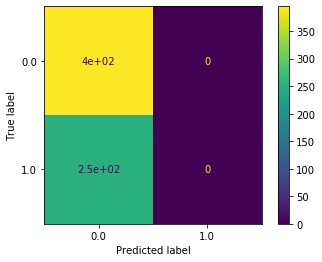

In [11]:
rand_1yr = DummyClassifier(strategy='most_frequent').fit(x_train_1yr, y_train_1yr)
plot_results(rand_1yr, x_test_1yr, y_test_1yr, save=True, name='rand_mf_1yr')

              precision    recall  f1-score   support

         0.0       0.61      0.57      0.59       395
         1.0       0.39      0.43      0.41       251

    accuracy                           0.51       646
   macro avg       0.50      0.50      0.50       646
weighted avg       0.52      0.51      0.52       646

Test accuracy: 0.5139318885448917


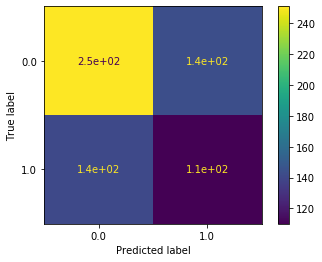

In [12]:
rand_1yr = DummyClassifier(strategy='stratified').fit(x_train_1yr, y_train_1yr)
plot_results(rand_1yr, x_test_1yr, y_test_1yr, save=True, name='rand_mf_1yr')

#### 3 year rate

              precision    recall  f1-score   support

         0.0       0.54      1.00      0.70       348
         1.0       0.00      0.00      0.00       298

    accuracy                           0.54       646
   macro avg       0.27      0.50      0.35       646
weighted avg       0.29      0.54      0.38       646

Test accuracy: 0.5386996904024768


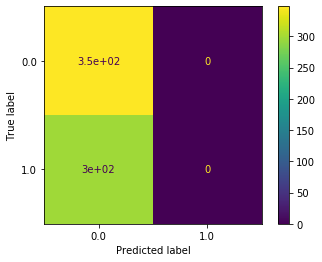

In [13]:
rand_3yr = DummyClassifier(strategy='most_frequent').fit(x_train_3yr, y_train_3yr)
plot_results(rand_3yr, x_test_3yr, y_test_3yr, save=True, name='rand_mf_3yr')

              precision    recall  f1-score   support

         0.0       0.52      0.49      0.51       348
         1.0       0.44      0.47      0.46       298

    accuracy                           0.48       646
   macro avg       0.48      0.48      0.48       646
weighted avg       0.49      0.48      0.49       646

Test accuracy: 0.5092879256965944


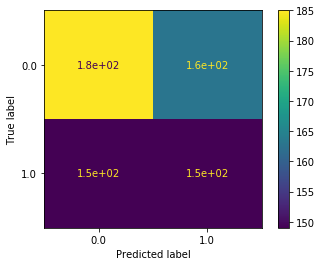

In [14]:
rand_3yr = DummyClassifier(strategy='stratified').fit(x_train_3yr, y_train_3yr)
plot_results(rand_3yr, x_test_3yr, y_test_3yr, save=True, name='rand_mf_3yr')

#### S&P

              precision    recall  f1-score   support

         0.0       0.55      1.00      0.71       356
         1.0       0.00      0.00      0.00       290

    accuracy                           0.55       646
   macro avg       0.28      0.50      0.36       646
weighted avg       0.30      0.55      0.39       646

Test accuracy: 0.5510835913312694


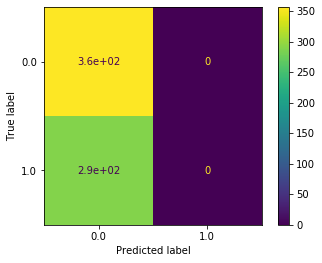

In [15]:
rand_sp = DummyClassifier(strategy='most_frequent').fit(x_train_sp, y_train_sp)
plot_results(rand_sp, x_test_sp, y_test_sp, save=True, name='rand_mf_sp')

              precision    recall  f1-score   support

         0.0       0.55      0.52      0.54       356
         1.0       0.45      0.48      0.47       290

    accuracy                           0.50       646
   macro avg       0.50      0.50      0.50       646
weighted avg       0.51      0.50      0.51       646

Test accuracy: 0.4984520123839009


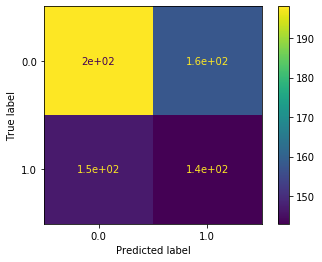

In [16]:
rand_sp = DummyClassifier(strategy='stratified').fit(x_train_sp, y_train_sp)
plot_results(rand_sp, x_test_sp, y_test_sp, save=True, name='rand_mf_sp')

### Logistic Regression with SBERT
#### 1 year rate

In [24]:
def calc_threshold_acc(model,x_test,y_test,alpha): 
    probs = model.predict_proba(x_test)
    pred_zero = np.where(probs[:,0]  > alpha)[0]
    pred_one = np.where(probs[:,1]  > alpha)[0]
    return (sum(y_test[pred_zero] == 0) + sum(y_test[pred_one] == 1)) / (len(pred_zero) + len(pred_one))

              precision    recall  f1-score   support

         0.0       0.65      0.77      0.70       395
         1.0       0.49      0.35      0.41       251

    accuracy                           0.61       646
   macro avg       0.57      0.56      0.56       646
weighted avg       0.59      0.61      0.59       646

Test accuracy: 0.6052631578947368


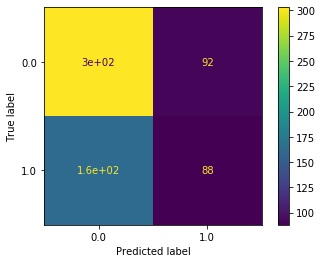

In [18]:
# Logistic regression
logreg_1yr = LogisticRegression(random_state=0,max_iter=10000).fit(x_train_1yr, y_train_1yr)
plot_results(logreg_1yr,x_test_1yr, y_test_1yr,save=True,name='logreg_1yr')

#### 3 year rate

              precision    recall  f1-score   support

         0.0       0.57      0.68      0.62       348
         1.0       0.51      0.40      0.45       298

    accuracy                           0.55       646
   macro avg       0.54      0.54      0.53       646
weighted avg       0.54      0.55      0.54       646

Test accuracy: 0.5464396284829721


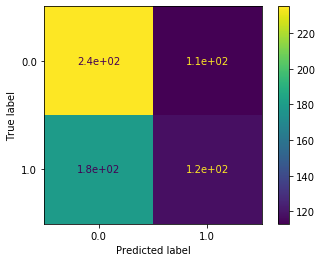

In [19]:
# Logistic regression
logreg_3yr = LogisticRegression(random_state=0,max_iter=10000).fit(x_train_3yr, y_train_3yr)
plot_results(logreg_3yr,x_test_3yr, y_test_3yr,save=True,name='logreg_3yr')

#### S&P 

              precision    recall  f1-score   support

         0.0       0.64      0.70      0.66       356
         1.0       0.58      0.51      0.54       290

    accuracy                           0.61       646
   macro avg       0.61      0.60      0.60       646
weighted avg       0.61      0.61      0.61       646

Test accuracy: 0.6130030959752322


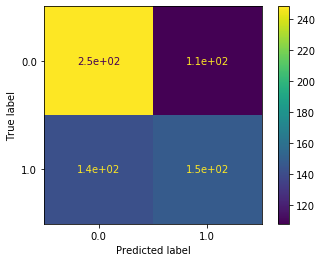

In [20]:
# Logistic regression
logreg_sp = LogisticRegression(random_state=0,max_iter=10000).fit(x_train_sp, y_train_sp)
plot_results(logreg_sp,x_test_sp, y_test_sp,save=True,name='logreg_sp')

In [41]:
preds = logreg_sp.predict_proba(x_test_sp)

In [49]:
tf.__version__

'1.15.0'

In [47]:
alpha = 0.80
calc_threshold_acc(logreg_sp, x_test_sp, y_test_sp, alpha)

0.7425742574257426

### Support Vector Machine with SBERT
#### 1 year rate

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.61      1.00      0.76       395
         1.0       0.00      0.00      0.00       251

    accuracy                           0.61       646
   macro avg       0.31      0.50      0.38       646
weighted avg       0.37      0.61      0.46       646

Test accuracy: 0.6114551083591331


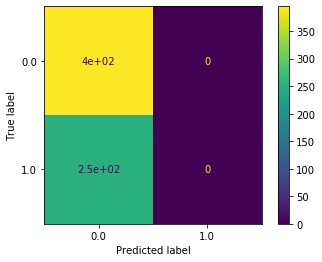

In [26]:
svm_clf_1yr = svm.SVC().fit(x_train_1yr, y_train_1yr)
plot_results(svm_clf_1yr, x_test_1yr, y_test_1yr,save=True,name='svm_1yr')

#### 3 year rate

              precision    recall  f1-score   support

         0.0       0.57      0.81      0.67       348
         1.0       0.57      0.30      0.39       298

    accuracy                           0.57       646
   macro avg       0.57      0.55      0.53       646
weighted avg       0.57      0.57      0.54       646

Test accuracy: 0.5743034055727554


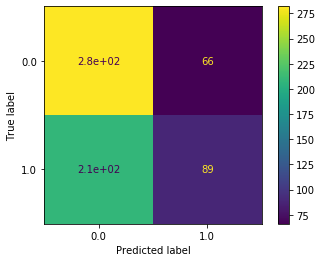

In [27]:
svm_clf_3yr = svm.SVC().fit(x_train_3yr, y_train_3yr)
plot_results(svm_clf_3yr, x_test_3yr, y_test_3yr,save=True,name='svm_3yr')

#### S&P 

              precision    recall  f1-score   support

         0.0       0.58      0.91      0.71       356
         1.0       0.65      0.20      0.31       290

    accuracy                           0.59       646
   macro avg       0.62      0.56      0.51       646
weighted avg       0.61      0.59      0.53       646

Test accuracy: 0.5928792569659442


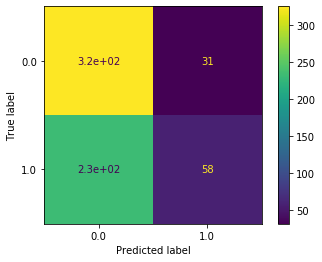

In [28]:
svm_clf_sp = svm.SVC().fit(x_train_sp, y_train_sp)
plot_results(svm_clf_sp, x_test_sp, y_test_sp,save=True,name='svm_sp')

### Random forest with SBERT
#### 1 year rate

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.2min finished


Best: 0.578450 using {'max_depth': 50, 'n_estimators': 750}
0.564527 (0.032231) with: {'max_depth': None, 'n_estimators': 250}
0.576115 (0.047120) with: {'max_depth': None, 'n_estimators': 500}
0.573097 (0.041055) with: {'max_depth': None, 'n_estimators': 750}
0.567261 (0.046729) with: {'max_depth': None, 'n_estimators': 1000}
0.561421 (0.050298) with: {'max_depth': 50, 'n_estimators': 250}
0.571075 (0.056060) with: {'max_depth': 50, 'n_estimators': 500}
0.578450 (0.027791) with: {'max_depth': 50, 'n_estimators': 750}
0.560598 (0.044680) with: {'max_depth': 50, 'n_estimators': 1000}
0.572942 (0.040847) with: {'max_depth': 100, 'n_estimators': 250}
0.574259 (0.043320) with: {'max_depth': 100, 'n_estimators': 500}
0.564585 (0.050521) with: {'max_depth': 100, 'n_estimators': 750}
0.577586 (0.040046) with: {'max_depth': 100, 'n_estimators': 1000}
              precision    recall  f1-score   support

         0.0       0.66      0.85      0.74       395
         1.0       0.56      0.29   

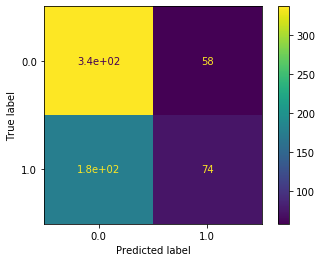

In [29]:
# Random Forest
rf_param_grid = dict(max_depth=[None, 50, 100],
                  n_estimators=[250, 500, 750, 1000])
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid, 
                       n_jobs=-1, 
                       cv=10, 
                       scoring='f1_weighted',
                       verbose=1)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    rf_grid_result = rf_grid.fit(x_train_1yr, y_train_1yr)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the model with the best parameters found in the cross validation. 
randomforest_1yr = RandomForestClassifier(max_depth=rf_grid_result.best_params_['max_depth'],
                                      n_estimators=rf_grid_result.best_params_['n_estimators']).fit(x_train_1yr, y_train_1yr)
plot_results(randomforest_1yr,x_test_1yr, y_test_1yr,save=True,name='rf_1yr_md{}_est_{}'.format(rf_grid_result.best_params_['max_depth'],
                                                                                rf_grid_result.best_params_['n_estimators']))

#### 3 year rate

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  6.2min finished


Best: 0.567078 using {'max_depth': None, 'n_estimators': 750}
0.550574 (0.038452) with: {'max_depth': None, 'n_estimators': 250}
0.560406 (0.034734) with: {'max_depth': None, 'n_estimators': 500}
0.567078 (0.043037) with: {'max_depth': None, 'n_estimators': 750}
0.562337 (0.043276) with: {'max_depth': None, 'n_estimators': 1000}
0.546315 (0.044945) with: {'max_depth': 50, 'n_estimators': 250}
0.555761 (0.034803) with: {'max_depth': 50, 'n_estimators': 500}
0.563752 (0.040012) with: {'max_depth': 50, 'n_estimators': 750}
0.556201 (0.052580) with: {'max_depth': 50, 'n_estimators': 1000}
0.548652 (0.049748) with: {'max_depth': 100, 'n_estimators': 250}
0.546038 (0.034010) with: {'max_depth': 100, 'n_estimators': 500}
0.545281 (0.031902) with: {'max_depth': 100, 'n_estimators': 750}
0.558922 (0.041116) with: {'max_depth': 100, 'n_estimators': 1000}
              precision    recall  f1-score   support

         0.0       0.58      0.70      0.64       348
         1.0       0.54      0.40 

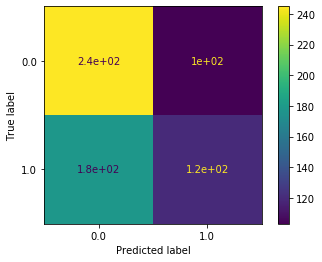

In [30]:
# Random Forest
rf_param_grid = dict(max_depth=[None, 50, 100],
                  n_estimators=[250, 500, 750, 1000])
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid, 
                       n_jobs=-1, 
                       cv=10, 
                       scoring='f1_weighted',
                       verbose=1)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    rf_grid_result = rf_grid.fit(x_train_3yr, y_train_3yr)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the model with the best parameters found in the cross validation. 
randomforest_3yr = RandomForestClassifier(max_depth=rf_grid_result.best_params_['max_depth'],
                                      n_estimators=rf_grid_result.best_params_['n_estimators']).fit(x_train_3yr, y_train_3yr)
plot_results(randomforest_3yr,x_test_3yr, y_test_3yr,save=True,name='rf_3yr_md{}_est_{}'.format(rf_grid_result.best_params_['max_depth'],
                                                                                rf_grid_result.best_params_['n_estimators']))

In [4]:
298 - 119

179

#### S&P 

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  6.3min finished


Best: 0.580853 using {'max_depth': 100, 'n_estimators': 500}
0.557087 (0.059865) with: {'max_depth': None, 'n_estimators': 250}
0.568082 (0.073125) with: {'max_depth': None, 'n_estimators': 500}
0.574846 (0.064610) with: {'max_depth': None, 'n_estimators': 750}
0.580411 (0.072619) with: {'max_depth': None, 'n_estimators': 1000}
0.570116 (0.052135) with: {'max_depth': 50, 'n_estimators': 250}
0.578627 (0.064401) with: {'max_depth': 50, 'n_estimators': 500}
0.579342 (0.048269) with: {'max_depth': 50, 'n_estimators': 750}
0.574882 (0.064079) with: {'max_depth': 50, 'n_estimators': 1000}
0.562452 (0.051706) with: {'max_depth': 100, 'n_estimators': 250}
0.580853 (0.047559) with: {'max_depth': 100, 'n_estimators': 500}
0.565335 (0.051551) with: {'max_depth': 100, 'n_estimators': 750}
0.579334 (0.054171) with: {'max_depth': 100, 'n_estimators': 1000}
              precision    recall  f1-score   support

         0.0       0.62      0.76      0.69       356
         1.0       0.60      0.43  

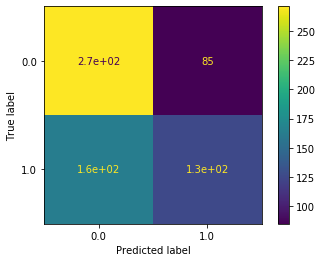

In [31]:
# Random Forest
rf_param_grid = dict(max_depth=[None, 50, 100],
                  n_estimators=[250, 500, 750, 1000])
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid, 
                       n_jobs=-1, 
                       cv=10, 
                       scoring='f1_weighted',
                       verbose=1)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    rf_grid_result = rf_grid.fit(x_train_sp, y_train_sp)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the model with the best parameters found in the cross validation. 
randomforest_sp = RandomForestClassifier(max_depth=rf_grid_result.best_params_['max_depth'],
                                      n_estimators=rf_grid_result.best_params_['n_estimators']).fit(x_train_sp, y_train_sp)
plot_results(randomforest_sp,x_test_sp, y_test_sp,save=True,name='rf_sp_md{}_est_{}'.format(rf_grid_result.best_params_['max_depth'],
                                                                                rf_grid_result.best_params_['n_estimators']))

### Neural Network, feed-forward

In [32]:
def create_model(nodes1=100, nodes2=50, dropout_rate=0.3, optimizer='rmsprop', learning_rate=0.001):
    if optimizer.lower() == 'rmsprop': 
        optimizer = RMSprop(learning_rate = learning_rate)
    elif optimizer.lower() == 'adam':
        optimizer = Adam(learning_rate = learning_rate)
    model = Sequential() 
    if nodes1 == 0: 
        model.add(Dense(1, input_shape=x_train_1yr.shape[1:], activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model 
    model.add(Dense(nodes1, input_shape=x_train_1yr.shape[1:]))
    model.add(Dropout(dropout_rate))
    if nodes2 == 0: 
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model
    model.add(Dense(nodes2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
    return model 

def randomize_params(params, n):
    test_params = []
    for i in range(n):
        temp_par = {}
        while True: 
            for par in params: 
                temp_par.update({par: np.random.choice(params[par])})
            if temp_par not in test_params: 
                test_params.append(temp_par)
                break
    return test_params

In [33]:
n_tests = 50
# Define possible parameters 
possible_params = dict(batch_size = [8, 16, 32],
                       nodes1 = [50, 100, 250, 500],
                       nodes2 = [0, 50, 100, 250, 500], # 0 implies only one hidden layer 
                       dropout_rate = [0.1, 0.3, 0.5],
                       learning_rate = [1e-3, 1e-4, 1e-5],
                       optimizer = ['RMSprop','Adam'])
test_params = randomize_params(possible_params, n_tests)

#### 1 year rate

In [34]:
historylist_1yr = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_1yr, y_train_1yr,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_1yr.append(history)
max_acc_1yr = -1
max_idx_1yr = -1
for i,hist in enumerate(historylist_1yr):
    if max(hist.history['val_acc']) > max_acc_1yr: 
        max_acc_1yr = max(hist.history['val_acc'])
        max_idx_1yr = i
    
print("Best val acc:",max_acc_1yr)
print("For config: ",test_params[max_idx_1yr])


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:14<00:00,  2.69s/it]

Best val acc: 0.6791667
For config:  {'nodes1': 50, 'nodes2': 500, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'optimizer': 'Adam', 'batch_size': 8}


Train on 960 samples, validate on 240 samples
Epoch 1/100000
960/960 [==============================] - 1s 2ms/sample - loss: 0.6794 - acc: 0.5844 - val_loss: 0.6457 - val_acc: 0.6542
Epoch 2/100000
960/960 [==============================] - 0s 309us/sample - loss: 0.6730 - acc: 0.6052 - val_loss: 0.6540 - val_acc: 0.6417
Epoch 3/100000
960/960 [==============================] - 0s 336us/sample - loss: 0.6618 - acc: 0.6031 - val_loss: 0.6509 - val_acc: 0.6708
Epoch 4/100000
960/960 [==============================] - 0s 313us/sample - loss: 0.6506 - acc: 0.6073 - val_loss: 0.6459 - val_acc: 0.6542
Epoch 5/100000
960/960 [==============================] - 0s 330us/sample - loss: 0.6546 - acc: 0.6146 - val_loss: 0.6629 - val_acc: 0.6042
Epoch 6/100000
960/960 [==============================] - 0s 330us/sample - loss: 0.6516 - acc: 0.6271 - val_loss: 0.6415 - val_acc: 0.6750
Epoch 7/100000
960/960 [==============================] - 0s 338us/sample - loss: 0.6425 - acc: 0.6229 - val_loss: 0

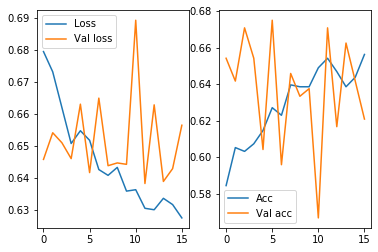

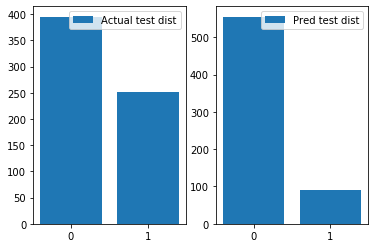

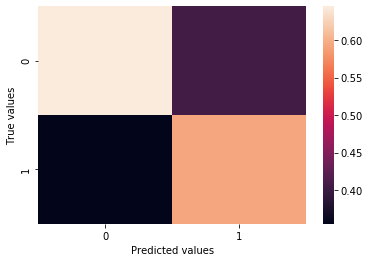

              precision    recall  f1-score   support

         0.0       0.65      0.91      0.75       395
         1.0       0.59      0.22      0.32       251

    accuracy                           0.64       646
   macro avg       0.62      0.56      0.53       646
weighted avg       0.62      0.64      0.58       646

Test accuracy: 0.638


In [35]:
bs = test_params[max_idx_1yr].pop('batch_size')
model_ff_1yr = create_model(**test_params[max_idx_1yr])
test_params[max_idx_1yr].update({'batch_size': bs})

history_1yr = model_ff_1yr.fit(x_train_1yr, y_train_1yr,
                               epochs=100000,
                               batch_size = bs,
                               verbose=1,
                               callbacks = [EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)],
                               validation_split=0.2)
savename_1yr = "nn_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_1yr]['batch_size'],
                                                          test_params[max_idx_1yr]['nodes1'],
                                                          test_params[max_idx_1yr]['nodes2'],
                                                          test_params[max_idx_1yr]['dropout_rate'],
                                                          test_params[max_idx_1yr]['learning_rate'],
                                                          test_params[max_idx_1yr]['optimizer'])
plot_results_nn(history_1yr,model_ff_1yr,x_test_1yr, y_test_1yr,save=True, name=savename_1yr)

#### 3 year rate

In [36]:
historylist_3yr = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_3yr, y_train_3yr,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_3yr.append(history)
max_acc_3yr = -1
max_idx_3yr = -1
for i,hist in enumerate(historylist_3yr):
    if max(hist.history['val_acc']) > max_acc_3yr: 
        max_acc_3yr = max(hist.history['val_acc'])
        max_idx_3yr = i
    
print("Best val acc:",max_acc_3yr)
print("For config: ",test_params[max_idx_3yr])

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [05:42<00:00,  6.84s/it]

Best val acc: 0.6666667
For config:  {'nodes1': 50, 'nodes2': 0, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'optimizer': 'RMSprop', 'batch_size': 16}


Train on 960 samples, validate on 240 samples
Epoch 1/100000
960/960 [==============================] - 3s 3ms/sample - loss: 0.8834 - acc: 0.5177 - val_loss: 0.7092 - val_acc: 0.6125
Epoch 2/100000
960/960 [==============================] - 0s 332us/sample - loss: 0.8082 - acc: 0.5188 - val_loss: 0.9122 - val_acc: 0.3917
Epoch 3/100000
960/960 [==============================] - 0s 307us/sample - loss: 0.7736 - acc: 0.5281 - val_loss: 0.6584 - val_acc: 0.6250
Epoch 4/100000
960/960 [==============================] - 0s 290us/sample - loss: 0.7697 - acc: 0.5406 - val_loss: 0.6535 - val_acc: 0.6417
Epoch 5/100000
960/960 [==============================] - 0s 313us/sample - loss: 0.7778 - acc: 0.5188 - val_loss: 0.6668 - val_acc: 0.6000
Epoch 6/100000
960/960 [==============================] - 0s 313us/sample - loss: 0.7545 - acc: 0.5365 - val_loss: 0.6756 - val_acc: 0.5792
Epoch 7/100000
960/960 [==============================] - 0s 319us/sample - loss: 0.7278 - acc: 0.5552 - val_loss: 0

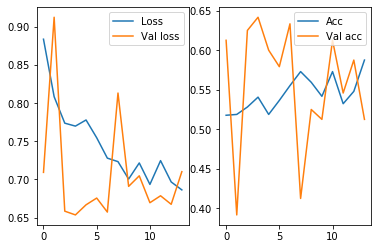

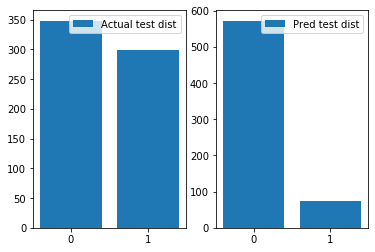

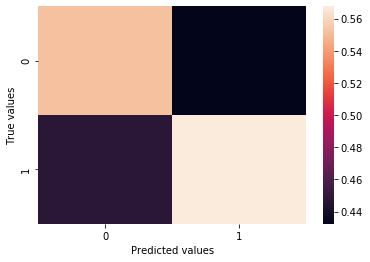

              precision    recall  f1-score   support

         0.0       0.55      0.91      0.69       348
         1.0       0.57      0.14      0.23       298

    accuracy                           0.55       646
   macro avg       0.56      0.52      0.46       646
weighted avg       0.56      0.55      0.47       646

Test accuracy: 0.554


In [37]:
bs = test_params[max_idx_3yr].pop('batch_size')
model_ff_3yr = create_model(**test_params[max_idx_3yr])
test_params[max_idx_3yr].update({'batch_size': bs})

history_3yr = model_ff_3yr.fit(x_train_3yr, y_train_3yr,
                               epochs=100000,
                               batch_size = bs,
                               verbose=1,
                               callbacks = [EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)],
                               validation_split=0.2)
savename_3yr = "nn_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_3yr]['batch_size'],
                                                          test_params[max_idx_3yr]['nodes1'],
                                                          test_params[max_idx_3yr]['nodes2'],
                                                          test_params[max_idx_3yr]['dropout_rate'],
                                                          test_params[max_idx_3yr]['learning_rate'],
                                                          test_params[max_idx_3yr]['optimizer'])
plot_results_nn(history_3yr,model_ff_3yr,x_test_3yr, y_test_3yr,save=True, name=savename_3yr)


#### S&P

In [38]:
historylist_sp = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_sp, y_train_sp,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_sp.append(history)
max_acc_sp = -1
max_idx_sp = -1
for i,hist in enumerate(historylist_sp):
    if max(hist.history['val_acc']) > max_acc_sp: 
        max_acc_sp = max(hist.history['val_acc'])
        max_idx_sp = i
    
print("Best val acc:",max_acc_sp)
print("For config: ",test_params[max_idx_sp])

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [09:54<00:00, 11.89s/it]

Best val acc: 0.60833335
For config:  {'nodes1': 250, 'nodes2': 500, 'dropout_rate': 0.1, 'learning_rate': 1e-05, 'optimizer': 'RMSprop', 'batch_size': 8}


Train on 960 samples, validate on 240 samples
Epoch 1/100000
960/960 [==============================] - 6s 6ms/sample - loss: 0.7068 - acc: 0.5042 - val_loss: 0.6902 - val_acc: 0.5667
Epoch 2/100000
960/960 [==============================] - 1s 1ms/sample - loss: 0.7093 - acc: 0.5094 - val_loss: 0.6835 - val_acc: 0.5667
Epoch 3/100000
960/960 [==============================] - 1s 2ms/sample - loss: 0.7008 - acc: 0.5208 - val_loss: 0.6817 - val_acc: 0.5708
Epoch 4/100000
960/960 [==============================] - 1s 2ms/sample - loss: 0.6964 - acc: 0.5292 - val_loss: 0.6791 - val_acc: 0.5667
Epoch 5/100000
960/960 [==============================] - 1s 2ms/sample - loss: 0.6902 - acc: 0.5417 - val_loss: 0.6831 - val_acc: 0.5583
Epoch 6/100000
960/960 [==============================] - 1s 1ms/sample - loss: 0.6834 - acc: 0.5615 - val_loss: 0.6770 - val_acc: 0.5667
Epoch 7/100000
960/960 [==============================] - 1s 2ms/sample - loss: 0.6871 - acc: 0.5552 - val_loss: 0.6753 - val_

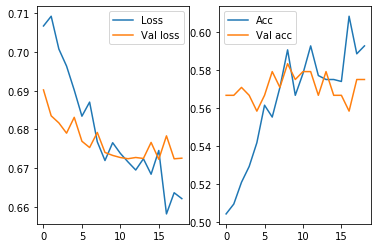

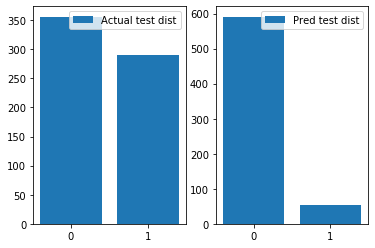

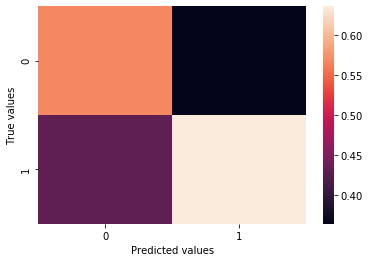

              precision    recall  f1-score   support

         0.0       0.57      0.94      0.71       356
         1.0       0.64      0.12      0.20       290

    accuracy                           0.57       646
   macro avg       0.60      0.53      0.46       646
weighted avg       0.60      0.57      0.48       646

Test accuracy: 0.574


In [39]:
bs = test_params[max_idx_sp].pop('batch_size')
model_ff_sp = create_model(**test_params[max_idx_sp])
test_params[max_idx_sp].update({'batch_size': bs})

history_sp = model_ff_sp.fit(x_train_sp, y_train_sp,
                               epochs=100000,
                               batch_size = bs,
                               verbose=1,
                               callbacks = [EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)],
                               validation_split=0.2)
savename_sp = "nn_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_sp]['batch_size'],
                                                          test_params[max_idx_sp]['nodes1'],
                                                          test_params[max_idx_sp]['nodes2'],
                                                          test_params[max_idx_sp]['dropout_rate'],
                                                          test_params[max_idx_sp]['learning_rate'],
                                                          test_params[max_idx_sp]['optimizer'])
plot_results_nn(history_sp,model_ff_sp,x_test_sp, y_test_sp,save=True, name=savename_sp)


## Results

The following results were achieved on the independent test set on the IMDB dataset. The reviews were encoded into 768-dimensional vectors using Sentence-BERT on each sentence in the reviews, and then reduced to one vector per review by taking the elementwise average over each dimension. 

| Model |  Test Accuracy (%)  | Hyperparameters |
| :----- | --------------- | --- | 
| Random Classifier | 50.6 | N/A |
| Logistic Regression | __90.7__  | N/A |
| Linear Discriminant Analysis | 90.3  | N/A |
| Support Vector Machine | 90.0 | N/A |
| Random Forest | 87.1  | n_estimators=5000, max_depth=None |
| XGBoost | 88.9 | n_estimators=500 |
| Multi Layer Perceptron | 89.8 | batch_size=16,depth=3,dropout_rate=0.2,nodes=250 |

Logistic Regression currently performs best. The hyperparameter tuning of the neural network-approaches is however not ideal, and would need more time/computational power to optimize further. It should however not be a too large improvement. Looking at the validation accuracy achieved from different configurations of hyperparameters on the neural network, it rarely reaches above 89 %. 

For comparison, the table below displays state-of-the-art models for the IMDB classification task. 

| Model |	Accuracy (%) |	Paper / Source|
|:----- | ---------- | -------------- |  
| XLNet (Yang et al., 2019) |	__96.21__ |	XLNet: Generalized Autoregressive Pretraining for Language Understanding|
| BERT_large+ITPT (Sun et al., 2019) 	|95.79 |	How to Fine-Tune BERT for Text Classification?|
| BERT_base+ITPT (Sun et al., 2019) |	95.63 |	How to Fine-Tune BERT for Text Classification?|
| ULMFiT (Howard and Ruder, 2018) |	95.4 |	Universal Language Model Fine-tuning for Text Classification|
| Block-sparse LSTM (Gray et al., 2017) |	94.99 |	GPU Kernels for Block-Sparse Weights|
| oh-LSTM (Johnson and Zhang, 2016)| 	94.1| 	Supervised and Semi-Supervised Text Categorization using LSTM for Region Embeddings |
| Virtual adversarial training (Miyato et al., 2016) |	94.1 	|Adversarial Training Methods for Semi-Supervised Text Classification |
| BCN+Char+CoVe (McCann et al., 2017) |	91.8 |	Learned in Translation: Contextualized Word Vectors |
